In [76]:
from qiskit import *
from qiskit.visualization import *
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.providers.ibmq import least_busy
import numpy as np
import math
from pylab import *
import matplotlib.pyplot as plt

In [3]:
IBMQ.load_accounts()

In [118]:
class DustCircuit(QuantumCircuit):
    def __init__(self, n_qbits, t, freq, alt_version=True):
        """Initializes the DustCircuit object
        
        Keyword arguments:
        n_qbits -- number of qbits of the circuit
        t -- temperature of the oscillator
        freq -- frequence of the oscillator
        alt_version -- Whether the circuit represent n_qbits oscillators with 2 states or an oscillator with 2^n_qbits states"
        """
        n_states = 2**n_qbits
        self.n_qbits = n_qbits
        self.alt_version = alt_version
        self.q = QuantumRegister(n_qbits, name="q")
        self.c = ClassicalRegister(n_qbits, name="c")
        self.dict_results = None
        self.statevector = None
        self.result = None        
        super().__init__(self.q,self.c)
        
        coefs = None
        if(alt_version): coefs = DustCircuit._generate_coefs2(n_qbits, t, freq)
        else: coefs = DustCircuit._generate_coefs1(n_states, t, freq)
        self.initialize(coefs, self.q)
        
    def simulate(self, nshots = 1000,backend=BasicAer.get_backend('qasm_simulator')):
        """Runs a standard simulation of the circuit
        To plot the results, execute circuit.plot()
        
        Keyword arguments:
        nshots -- number of iterations of the simulation
        backend -- backend to employ in the simulation        
        """
        
        self.result = execute(self, backend, shots=nshots).result()        
        self.counts = self.result.get_counts(self)
        self.dict_results = {}
        if(self.alt_version):
            self.dict_results['0'] = self.counts['0'*self.n_qbits]            
            self.dict_results['1'] = nshots-self.dict_results['0']
        else:
            for key in list(self.counts.keys()):
                self.dict_results[int(key,2)] = self.counts[key]
        return self.result
    
    def simulate_statevector(self):
        """Runs a statevector simulation of the circuit
        To plot the results, execute circuit.plot('statevector')"""
        
        self.result = execute(self, BasicAer.get_backend('statevector_simulator')).result()
        self.statevector = self.result.get_statevector(self)
        return self.result
    def execute(self, nshots = 1000, max_credits=3):
        """Sends a petition to execute the circuit to an IBM backend
        To plot the results, execute circuit.plot()
        Keyword arguments:
        nshots -- number of iterations of the simulation
        max_credits -- max number of credits to employ
        """
        
        large_enough_devices = IBMQ.backends(filters=lambda x: x.configuration().n_qubits < 10 and
                                                       not x.configuration().simulator)
        backend = least_busy(large_enough_devices)
        self.result = execute(self, backend, shots=nshots, max_credits=max_credits).result()
        self.counts = self.result.get_counts(self)
        self.dict_results = {}
        if(self.alt_version):
            self.dict_results['0'] = self.counts['0'*self.n_qbits]            
            self.dict_results['1'] = nshots-self.dict_results['0']
        else:
            for key in list(self.counts.keys()):
                self.dict_results[int(key,2)] = self.counts[key]
        return self.result
    
    def plot(self, how='histogram'):
        """Plots the current data obtained through simulation or execution of the circuit
        
        Keyword arguments:
        how -- 'histogram' to see histogram of standard results, 'state_city' to visualize statevector
        max_credits -- max number of credits to employ
        """
        
        fig = None
        if (how == 'histogram'): fig = \
         plot_histogram(self.dict_results)
        elif (how == 'state_city'): fig = \
         plot_state_city(self.statevector)
        return fig    
    
    def sim_and_exec(self, nshots = 1000, sim_backend = BasicAer.get_backend('qasm_simulator'), credits=3):
        """Simulates and executes the circuit, storing both as a tuple
        To plot both results, execute circuit.plot()
        
        Keyword arguments:
        nshots -- number of iterations of the simulation
        sim_backend -- backend to employ in the simulation        
        max_credits -- max number of credits to employ
        """
        
        self.simulate(nshots, backend=sim_backend)
        sim_results = self.dict_results        
        self.execute(nshots, max_credits=credits)
        self.dict_results = [sim_results, self.dict_results]        
        
    @staticmethod
    def _generate_coefs1(tam, t, freq):
        """Generates the vector of coefficients to initialize the multiple step
        oscillator
        
        Keyword arguments:
        tam -- number of quantum states
        t -- temperature of the oscillator
        freq -- frequence of the oscillator
        """
        h, kB = 6.582119624 * 10**(-16), 8.6173324*10**(-5) #ctes    
        E = [h*freq*(i+1/2) for i in range(tam)]
        cNumerador = [math.exp(-E[i]/(kB*t)) for i in range(tam)]     
        sumDenom = math.sqrt(sum(cNumerador))
        c = [math.sqrt(cNumerador[i])/sumDenom for i in range(tam)]
        return c
    @staticmethod
    def _generate_coefs2(n, t, freq):
        """Generates the vector of coefficients to initialize the multiple step
        oscillator
        
        Keyword arguments:
        n -- number of q_bits
        t -- temperature of the oscillator
        freq -- frequence of the oscillator
        """
        
        tam = 2**n
        h, kB = 6.582119624 * 10**(-16), 8.6173324*10**(-5) #ctes    
        E = []
        for i in list(map(lambda b: str(bin(b))[2:],range(tam))):
            mult = i.count('1')+n/2
            E.append(h*freq*mult)
        cNumerador = [math.exp(-E[i]/(kB*t)) for i in range(tam)]     
        sumDenom = math.sqrt(sum(cNumerador))
        c = [math.sqrt(cNumerador[i])/sumDenom for i in range(tam)]
        return c

In [119]:
t, freq = 15*10**9, 1.55*10**21 
c = DustCircuit(3, t, freq)
c.measure(c.q, c.c)
c.draw()
#c.sim_and_exec()

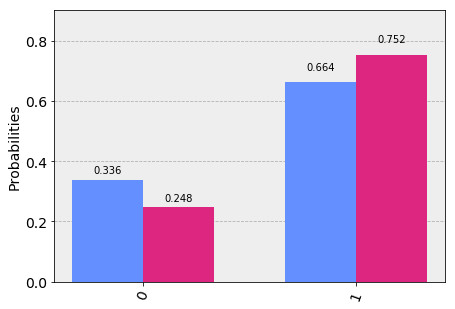

In [67]:
c.plot()

In [108]:
t, freq = 15*10**9, 1.55*10**21
max, shots = 5, 1000
x = range(1,max+1)
y0, y1 = [], []
for i in x:    
    c = DustCircuit(i, t, freq)
    c.measure(c.q, c.c)
    c.simulate(nshots=shots)
    y0.append(c.dict_results['0']/shots)
    y1.append(c.dict_results['1']/shots)

In [96]:
y0r , y1r = [], []
for i in x:    
    c = DustCircuit(i, t, freq)
    c.measure(c.q, c.c)
    c.execute(nshots=shots)
    y0r.append(c.dict_results['0']/shots)
    y1r.append(c.dict_results['1']/shots)

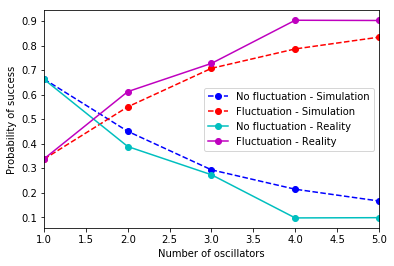

In [98]:
xlim(1,max)
xlabel("Number of oscillators")
ylabel("Probability of success")
p0 = plot(x, y0, 'bo--', label = "No fluctuation - Simulation")
p1 = plot(x, y1, 'ro--', label = "Fluctuation - Simulation")
p0r = plot(x, y0r, 'co-', label = "No fluctuation - Reality")
p1r = plot(x, y1r, 'mo-', label = "Fluctuation - Reality")

legend(loc='center right')
p0+p1+p0r+p1r


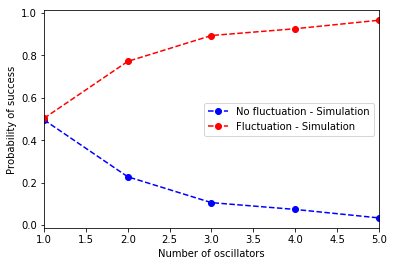

In [109]:
xlim(1,max)
xlabel("Number of oscillators")
ylabel("Probability of success")
p0 = plot(x, y0, 'bo--', label = "No fluctuation - Simulation")
p1 = plot(x, y1, 'ro--', label = "Fluctuation - Simulation")
#p0r = plot(x, y0r, 'co-', label = "No fluctuation - Reality")
#p1r = plot(x, y1r, 'mo-', label = "Fluctuation - Reality")

legend(loc='center right')
p0+p1#+p0r+p1r


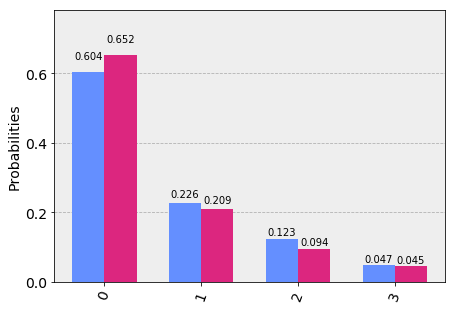

In [19]:
c.plot()